In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [4]:
def gaussian_noise(x, scale = 0.8):
    #가우스 노이즈를 더해줌
    gaussian_data_x = x+np.random.normal(loc=0, scale=scale, size = x.shape)

    #이미지의 픽셀값을 0과 1 사이로 정규화
    gaussian_data_x = np.clip(
        gaussian_data_x, 0,1
    )

    gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    return gaussian_data_x

In [5]:
training_data = MNIST(
    root="./",
    train = True,
    download = True,
    transform=ToTensor()
)
test_data = MNIST(
    root="./",
    train = False,
    download = True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 23687771.87it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14438104.15it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8760425.20it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 13715283.49it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [7]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):
        #원본 데이터
        self.mnist = MNIST(
            root = "./",
            train = True,
            download = True,
            transform = ToTensor()
        )
        #노이즈가 낀 데이터를 담는 리스트
        self.data = []

        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i])
            input_tensor = torch.tensor(noisy_input)
            self.data.append(torch.unsqueeze(input_tensor, dim=0))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        data = self.data[i]
        label = self.mnist.data[i]/255
        return data, label

In [13]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            hidden_dim,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim,
            out_channels,
            kernel_size=3,
            padding=1
        )
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = BasicBlock(in_channels =1, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)

        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv1 = BasicBlock(in_channels =8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)

        #출력층은 기본 블록이 아닌 합성곱층
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        #업샘플링
        self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)

        return x

In [19]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)

        return(x)


In [20]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda"

trainset = Denoising() #학습에 이용할 데이터셋
train_loader = DataLoader(trainset, batch_size=32)

model = CAE().to(device)

lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)

    for data, label in iterator:
        optim.zero_grad()
        pred = model(data.to(device))

        loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
        #TensorBoard에 정보 기록
        writer.add_scalar("Loss/train", loss, epoch)

        loss.backward()
        optim.step()
        iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")
        
torch.save(model.state_dict(), "./CAE.pth")
writer.flush()


C:\Users\wjdrb\AppData\Local\Temp\ipykernel_150912\1954837502.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
C:\Users\wjdrb\AppData\Local\Temp\ipykernel_150912\3228615721.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch20 loss:0.007554879877716303: 100%|██████████| 1875/1875 [00:05<00:00, 324.63it/s] 


C:\Users\wjdrb\AppData\Local\Temp\ipykernel_150912\1954837502.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


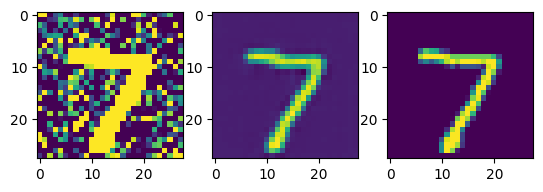

In [21]:
model.cpu()

with torch.no_grad():
    model.load_state_dict(torch.load("./CAE.pth", map_location=device))

    img = test_data.data[0]
    gaussian = gaussian_noise(img)

    input = torch.unsqueeze(gaussian, dim=0)
    input.type(torch.FloatTensor).to(device)
    input = torch.unsqueeze(input, dim=0)

    plt.subplot(1,3,1)
    plt.imshow(torch.squeeze(gaussian))
    plt.subplot(1,3,2)
    plt.imshow(torch.squeeze(model(input)))
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(img))
    plt.show()